<a href="https://colab.research.google.com/github/Auckland68/Projects/blob/main/Lab_Sheet_3_1806874_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCDSA04 Data Exploration & Analysis - Lab Sheet 3

Please complete the following exercises by the  19/12/19.

**Important information:**

This lab sheet contains a number of exercises for you to complete. For each task please open up code cells directly below the task text cell to answer the question. When writing the solution to each task please use text boxes or comments within the code to explain what you are doing and your thought process. The marks you recieve for each task will be based on the correctness of your answer and your workings. Meaning that if you have clearly explained your thinking and how you are going to complete the task then you will receive method marks even if you final answer is incorrect (provided your approach was valid).

Each of the tasks have been allocated a percentage mark which indicates how much each task of the lab sheet is worth overall.
 

**Submitting your work**

Once you have completed the sheet please:

1. Share your colab notebook with me.
2. Download the .py version of the notebook and upload it onto the Moodle page.


## Task 1 - 10%

The retailing manager of supermarket chain wants to determine whether product location has any effect on the sale of pet toys. Three different aisle locations are considere: front, middle and rear. A random sample of 18 stores is selected with 6 stores randomly assigned to each aisle location. The size of the display area and price of the product are constant for all stores. At the end of a one-month trial period, the sales volumnes (in thousands of dollars) of the product in each store are recorded and stored in the following csv file.

https://github.com/cm326/Data/raw/master/Location.csv

Use this data to answer the following:

1. At the 0.05% level of significance, is there evidence of a significant difference in average sales among the various aisle locations?

2. If appropriate, which aisle locations appear to differ significantly in average sales?

3. What should the retailing manager conclude? 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
plt.style.use("seaborn")
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#### Examination of Dataset

In [ ]:
url = "https://raw.githubusercontent.com/cm326/Data/master/Location.csv"
pets = pd.read_csv(url, sep = ",")
pets.columns = ["Front","Middle","Rear"]

In [ ]:
pets.head(6)

,Front,Middle,Rear
0,8.6,3.2,4.6
1,7.2,2.4,6.0
2,5.4,2.0,4.0
3,6.2,1.4,2.8
4,5.0,1.8,2.2
5,4.0,1.6,2.8


In [ ]:
pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
Front     6 non-null float64
Middle    6 non-null float64
Rear      6 non-null float64
dtypes: float64(3)
memory usage: 272.0 bytes


In [ ]:
aisle = pd.melt(pets, value_vars=pets.columns, var_name = 'Location', value_name = 'Sales').dropna()
aisle.head(10)

,Location,Sales
0,Front,8.6
1,Front,7.2
2,Front,5.4
3,Front,6.2
4,Front,5.0
5,Front,4.0
6,Middle,3.2
7,Middle,2.4
8,Middle,2.0
9,Middle,1.4


In [ ]:
aisle.groupby("Location")["Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
Front,6.0,6.066667,1.647625,4.0,5.10,5.8,6.95,8.6
Middle,6.0,2.066667,0.653197,1.4,1.65,1.9,2.30,3.2
Rear,6.0,3.733333,1.417980,2.2,2.80,3.4,4.45,6.0


For each location the mean and median values are fairly close, which we would expect if they were normally distributed.

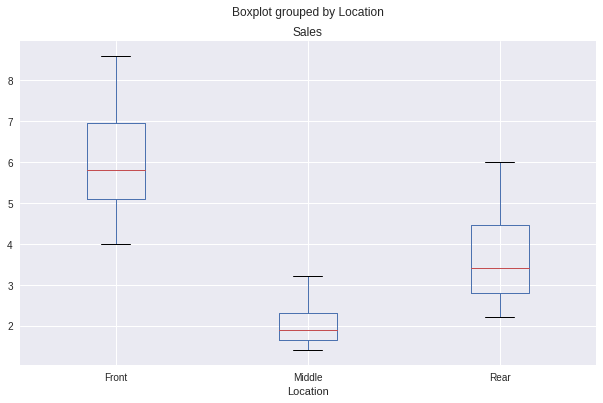

In [ ]:
ax = aisle.boxplot(column = ["Sales"], by = "Location",figsize = (10,6))

From the boxplots, the front location clearly has a higher mean, with the middle location recording the lowest of the three. There are no outliers.

To compare the means of the three locations, we can use ANOVA with the assumptions:


*   sales volumes for each location are independent to any other location
*   sales volumes are normally distributed for each location
*   variance of sales volumes is the same for all locations

The data was randomly selected so we can assume the first condition has been met. 

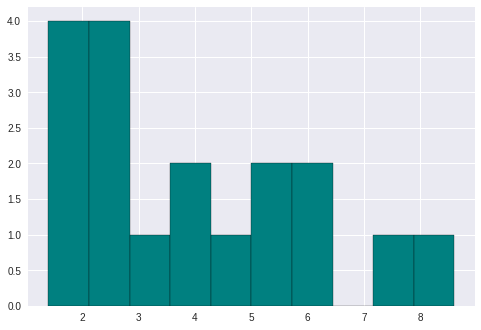

In [ ]:
ax = aisle["Sales"].hist(ec = "black",color = "teal")

In [ ]:
stats.skew(aisle["Sales"])

0.6548591806925191

In [ ]:
# accept null hypothesis, data normally distributed
stats.shapiro(aisle["Sales"])

(0.9319248199462891, 0.20990495383739471)

The histogram for all locations doesn't appear normally distributed, there is a positive skew. However, the sample size is quite small. ANOVA is robust to small departures from normality.
Running the shapiro test we accept the null hypothesis of being normally distributed, the data is not statistically different from normal.

In [ ]:
# Test for equality of variances
stats.levene(pets["Front"].dropna(),pets["Middle"].dropna(),pets["Rear"].dropna())

LeveneResult(statistic=1.9729514717581547, pvalue=0.17350805111188528)

In [ ]:
stats.bartlett(pets["Front"].dropna(),pets["Middle"].dropna(),pets["Rear"].dropna())

BartlettResult(statistic=3.5675577457384087, pvalue=0.1680020877001968)

Running statistical tests for equality of variances, the p value is greater than 5% so we cannot reject the null hypothesis, the population variances are equal.

It appears that the assumptions for ANOVA have been met.

#### ANOVA Test

Q1 At the 0.05% level of significance, is there evidence of a significant difference in average sales among the various aisle locations?


H0 : There is no difference in average sales among aisle locations 

H1: There is a difference in average sales among aisle locations


Using amended function written by C.M. to return an ANOVA table of results:

In [ ]:
def Anova_Table(data):

  data_flat = pd.melt(data, value_vars=data.columns, var_name = 'Group', value_name = 'Value').dropna()

  n = len(data_flat)
  k = len(data.columns)
  dfn = k - 1
  dfd = n - k
 
  # Calculate SST 

  sample_mean = data_flat['Value'].mean()
  Dist = data_flat['Value'] - sample_mean
  Dist_sq = Dist**2
  SST = Dist_sq.sum()

  # Calculate SSA

  group_means = data.mean()
  group_numbers = data.count()

  group_dist = group_means - sample_mean
  group_dist_sq = group_dist**2

  x = group_dist_sq*group_numbers

  SSA = x.sum()

  # Calculate SSW

  Within_Group_Dist = data - group_means
  Within_Group_Dist_sq = Within_Group_Dist**2

  SSW = Within_Group_Dist_sq.sum().sum()

  # Calculate MST, MSA, MSW
  n = data_flat['Value'].count()
  c = data.shape[1]

  df_SST = n-1
  df_SSA = c-1
  df_SSW = n-c

  MST = SST/df_SST
  MSA = SSA/df_SSA
  MSW = SSW / df_SSW

  # F-stat

  F_critical = round(stats.f.ppf(0.95, dfn=dfn, dfd=dfd),2)
  F_stat = MSA / MSW

  # p-value
  F_Distribuion = stats.f(dfn = df_SSA, dfd = df_SSW)
  p_value = F_Distribuion.sf(F_stat)

  anova_table = pd.DataFrame( { 'Dof': [df_SSA,df_SSW,df_SST], 'SoS': [SSA, SSW, SST], 'MSoS': [MSA, MSW, ''], 'F-Stat':[F_stat,'',''], 'P-Value':[p_value,'','']  } , index = ['Among','Within','Total'] )
  print("F-critical value at 95%: ",F_critical)
  print("\n","\n")

  return anova_table

In [ ]:
Anova_Table(pets)

F-critical value at 95%:  3.68

 



,Dof,SoS,MSoS,F-Stat,P-Value
Among,2,48.444444,24.2222,14.1046,0.000357989
Within,15,25.760000,1.71733,,
Total,17,74.204444,,,


In [ ]:
# Running a check with the stats.f.oneway function
anova = stats.f_oneway(aisle["Sales"][aisle["Location"] == "Front"],aisle["Sales"][aisle["Location"]=="Middle"],aisle["Sales"][aisle["Location"]=="Rear"])
print('The p-value resulting from this test is %f' %anova[1])
print('The test statistic is %f' %anova[0])

The p-value resulting from this test is 0.000358
The test statistic is 14.104555


F-Test:

H0 - F-statistic > critical value

H1 - F-statistic < critical value

The F-statistic is well above the critical value, so the variability between the locations is much larger than within locations.

The p-value is < 0.05, so the findings are unlikely if the null hypothesis is true, so we can reject the null and conclude that there is indeed a difference between sales according to location.

### Which aisles differ

Using the Tukey Honest Significance Difference Test we can determine which aisle locations are significantly different in terms of mean sales.

H0: 


In [ ]:
from statsmodels.stats.multicomp import MultiComparison
test = MultiComparison(aisle["Sales"],aisle["Location"])
result = test.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Front Middle     -4.0  0.001 -5.9645 -2.0355   True
 Front   Rear  -2.3333 0.0194 -4.2978 -0.3689   True
Middle   Rear   1.6667  0.103 -0.2978  3.6311  False
----------------------------------------------------


The meandiff (difference between the group means) of the Front - Middle and Front - Rear is -4.0 and -2.33 respectively, suggesting that the Front location has the higher mean sales and is therefore the best.

Based on this test, we can reject the null hyposthesis of no difference between location in the store for the front and middle and front and rear but cannot reject the null hypothesis for any difference between the middle and the rear of the stores. 

The store manager can conclude that the location of pet products does have an impact on sales volume of products. Assuming all the displays were the same, including the type of products, the analysis suggests that placing products in the front of aisle location will increase sales volume. 

## Task 2 - 40%

The task for this lab sheet is to create your own simple linear regression function from 'scratch'. Here by scratch means that you need to create the function using the formulas covered in class and not just use the output of pre-built packages such as `statsmodels`. You can use packages to for things like t-distributions in order to find p-values but you cannot directly use the output of any functionality for linear regression. The goal here is to use the formulas and theory covered in class.

The function you create needs to be able to take $x$ (the independent variable) and $y$ (the dependent variable) and fit the best line to the data using ordinary least square regression. The function should output the following:

1. The estimates for $\beta_0$ and $\beta_1$ i.e. $\hat{\beta}_0$ and $\hat{\beta}_1$.
2. The R-sqruared score.
3. A Pandas Dataframe containing $\beta_1$ along with the corresponding standard error, t-stat value, p-value and 95% confidence interval.
4. A Pandas Dataframe which is the ANOVA table testing the null hypothesis of $\beta_1 = 0$.
5. The residuals in a Pandas Series.



In [ ]:
# simple linear regression function - one independent variable [NOTE: inputs to function must be Series objects]
def my_func(x,y):

  # number of observations, number of independent variables
  m = len(x)
  k = 1
  
  # Means of x and y, sum of xy, sum of x-squared, Sxy and Sxx
  mean_x = x.mean()
  mean_y = y.mean()
  sum_of_xy  = (x*y).sum()
  x_square = (x**2).sum() 
  s_x_y= sum_of_xy - m*(mean_x*mean_y)
  s_x_x = x_square - m*(mean_x**2)
  
  # slope and intercept of fitted line
  slope = s_x_y/s_x_x
  intercept =  mean_y-(slope*mean_x)
  print("Slope of the line (B1): ",round(slope,4))
  print("Intercept of the line (B0): ",round(intercept,2),"\n")
      
  # Total sum of squares, regression sum of squares, standard error of the estimate and r-squared
  results = []
  for i in y:
      results.append((i - mean_y)**2)
  sst = pd.Series(results).sum()
  ssr  = ((s_x_y)**2)/s_x_x
  sse = sst-ssr
  r_squared = ssr/sst
  print("R square value: ",round(r_squared,4))
  standard_error_reg = round(((sse/(m-2))**0.5),2)
          
  # Standard error of the slope 
  ses = (sse/(m-2))**0.5/(((x-mean_x)**2).sum()**0.5)
          
  # t statistic, critical value and p-value
  t_s= (slope-0)/ses
  t_crit_val = stats.t.ppf(0.975,m-2)
  t_p = stats.t.sf(np.abs(t_s), m-2)*2 
  
  # confidence intervals of the slope
  lower_ci = slope - (t_crit_val*ses)
  upper_ci = slope + (t_crit_val*ses)
     
  # F stats, critical value and p-value
  df1 = k   
  df2 = m-k-1
  msr = ssr/df1
  mse = sse/df2
  f_crit = stats.f.ppf(0.95, dfn=df1, dfd=df2)
  f_stat = msr/mse
  f_p= stats.f.sf(f_stat,df1,df2)

  # T-test and F-Test Analysis:
  print("\n")
  print("T_crit:",round(t_crit_val,2))
  if t_s > t_crit_val or t_s < -t_crit_val:
    print("Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y")
  else:
    print("Fail to reject the null hypothesis B1 = 0, there is insufficient evidence that the independent variable x affects the dependent variable y,\n")
  print("F-crit: ",round(f_crit,2))
  if f_stat > f_crit:
    print("Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model")  
  else:
    print("Fail to reject the hypothesis B1 = 0, there is insufficient evidence that the model fits the data better than an intercept only model y,\n")
      
  # Residuals
  predict_vals = []
  x_vals = np.asarray(x)
  for i in x_vals:
    predict = round(i*slope+intercept,2)
    predict_vals.append(predict)
  predict_vals = pd.Series(predict_vals)
  residuals = y - predict_vals
      
  # Tables of results
  reg_results = pd.DataFrame( { 'Coefficient': [intercept,slope], 'SE': ['',ses], 'T-Stat': ['',t_s], 'P-Value':['',t_p], 'CI Lower 95%': ['',lower_ci] , 'CI Upper 95%': ['',upper_ci] } , index = ["Intercept","Slope"])
  anova_table = pd.DataFrame( { 'Dof': [df1,df2,m-1], 'SS': [ssr, sse, sst], 'MS': [msr,mse,''], 'F-Stat':[f_stat,'',''], 'P-Value':[f_p,'','']  } , index = ['Regression','Residual','Total'] )
  residual_df = pd.DataFrame(residuals,columns = ["Residuals"]).T
 
  print("\n")
  return reg_results,anova_table,residual_df
  
#result = my_func(x,y)

In [ ]:
# TEST CODE: test of the code using data from class slides:
house_price = pd.Series([245,312,279,308,199,219,405,324,319,255])
square_feet = pd.Series([1400,1600,1700,1875,1100,1550,2350,2450,1425,1700])
result = my_func(square_feet,house_price)
# print out the tables:
result[0]

Slope of the line (B1):  0.1098
Intercept of the line (B0):  98.25 

R square value:  0.5808


T_crit: 2.31
Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y
F-crit:  5.32
Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model




,Coefficient,SE,T-Stat,P-Value,CI Lower 95%,CI Upper 95%
Intercept,98.248330,,,,,
Slope,0.109768,0.0329694,3.32938,0.010394,0.0337401,0.185795


In [ ]:
# ANOVA table
result[1]

,Dof,SS,MS,F-Stat,P-Value
Regression,1,18934.934776,18934.9,11.0848,0.010394
Residual,8,13665.565224,1708.2,,
Total,9,32600.500000,,,


In [ ]:
# residuals table
result[2]

,0,1,2,3,4,5,6,7,8,9
Residuals,-6.92,38.12,-5.85,3.94,-19.99,-49.39,48.8,-43.18,64.33,-29.85


## Task 3 - 20%

Now create a function which will output a Pandas Datafame containing the 95% confidence interval for the mean value of $y$ given $x$ and the 95% prediction interval for the value of $y$ given $x$. Note: You need to decide what inputs the function will need. 

In [ ]:
# mean value of y given a particular x - average value of y for a given x
#We shall now see how we can obtain the confidence intervals for mean y value for a given x_i and the prediction interval for the value of y given an x_i.

def conf_int(x_val,x,slope,intercept):

  m = len(x)
  y_predicted = slope * x_val + intercept
   
  # mean x
  mean_of_x = x.mean()
  x_square = (x**2).sum()
  s_x_x = x_square - m*(mean_of_x**2)
 
  # standard error of the estimate
  sse = result[1]["SS"].loc["Residual"]
  standard_error_est = ((sse/(m-2))**0.5)
  
  # calculate the h1 as per CM lecture slides:
  h1 = ((1/len(x)) + (((x_val - mean_of_x)**2)/s_x_x))
  root_h1 = (h1**0.5)
  pred_root = ((1 + h1)**0.5)

  # t-stat
  t_crit = stats.t.ppf(0.975,m-2)
  
  # confidence interval for the mean of y and prediction intervals for individual y 
  upper_ci = y_predicted + t_crit * standard_error_est * root_h1
  lower_ci = y_predicted - t_crit * standard_error_est * root_h1
  upper_pi = y_predicted + t_crit * standard_error_est * pred_root
  lower_pi =  y_predicted - t_crit * standard_error_est * pred_root
  
  # Dataframe
  conf_and_pred = pd.DataFrame( { 'CI lower': [lower_ci], 'CI Upper': [upper_ci], 'PI Lower': [lower_pi], 'PI Upper': [upper_pi]} , index = ["Results"])

  return(conf_and_pred)
  
# function - input value of x that you are interested in, the x variable, the slope and intercept which are taken from the previous function output dataframes
#conf_int(x_val,x,slope,intercept)

In [ ]:
# TEST CODE: using test data from class slides, enter value of x. Slope and intercept taken from previous dataframes output to the function to return the CI and PIs for that value.
conf_int(2000,square_feet,result[0]["Coefficient"].loc["Slope"],result[0]["Coefficient"].loc["Intercept"])

,CI lower,CI Upper,PI Lower,PI Upper
Results,280.664311,354.903299,215.502565,420.065046


## Task 4 - 10%

The task is now to use your linear regression model to the following data:

https://github.com/cm326/Data/raw/master/Movie.csv

This data contains the amount of money different movies grossed at the box office (in millions of dollars) and the money grossed from DVD sales (also in millions of dollars). 

A company has the rights to distributed DVDs and would like to obtain an estimate for the amount of money they can expect to gross from a movie based on it's corresponding box office figures. 

With this in mind complete the following:

1. Please begin by exploring the data and decide if a simple linear regression model seems appropriate. 

2. Once you have done this fit your simple linear regression model using the function you created earlier. Interpret your model. 

3. Plot the line of your simple linear regression model on top of the scatter of the data.

4. How much of the variation in the reponse variable is explained by the variation in your regression model?

6. Check that the assumptions of your model are satisfied.

7. Use a t-test and an F-test to test the null hypothesis that there is no linear relationship between your $x$ and $y$ variables. 

8. Plot the 95% confidence interval for the mean value of $y$ for a given $x$ on a scatter plot with the simple linear regression line. 

9. On the same plot now also include the 95% prediction interval for the value of $y$ for a given $x$.


### Exploring the Data

In [ ]:
movies = pd.read_csv("https://raw.githubusercontent.com/cm326/Data/master/Movie.csv", sep = ",")
movies.head()

,Title,2013 Gross ($mil),2014 DVD Revenue ($mil)
0,The Hunger Games: Catching Fire,407.140,54.925
1,Despicable Me 2,367.957,34.813
2,Frozen,296.692,185.483
3,Man of Steel,291.046,29.803
4,Gravity,255.622,24.350


In [ ]:
movies.columns = ["title","2013_gross","2014_dvd"]

In [ ]:
# Look at the columns and check for null or missing values
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
title         38 non-null object
2013_gross    38 non-null float64
2014_dvd      38 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [ ]:
# Look at summary statistics
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
2013_gross,38.0,113.115763,104.329444,0.327,42.8865,69.5055,152.82575,407.140
2014_dvd,38.0,19.892921,29.393184,5.538,9.0270,12.3910,20.05750,185.483


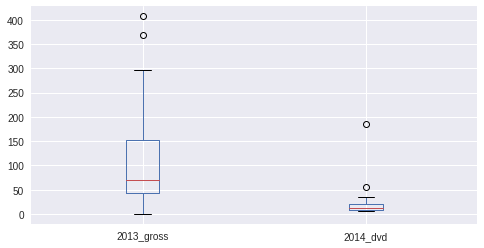

In [ ]:
# Boxplots of the data
ax = movies.boxplot(figsize = (8,4))

There appear to be a few outliers in the data. 

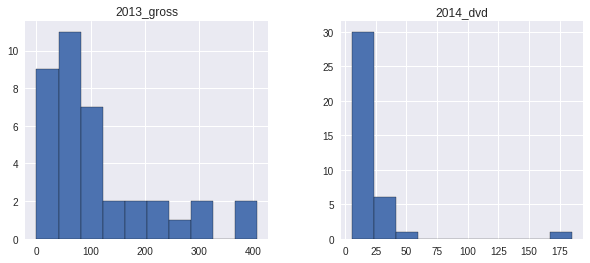

In [ ]:
# Histograms of the data
fig = plt.figure(figsize = (10,4))
ax = fig.gca()
movies.hist(ax=ax,ec = "black")
plt.show()

Most movies make up to around 120 million and dvds up to around 25 million dollars. The data for both is a positively skewed distribution. The outliers are very clear for dvd sales.

In [ ]:
# How is the data correlated?
movies.corr()

,2013_gross,2014_dvd
2013_gross,1.000000,0.528412
2014_dvd,0.528412,1.000000


The correlation matrix shows a positive relationship between the variables of about 0.53. 

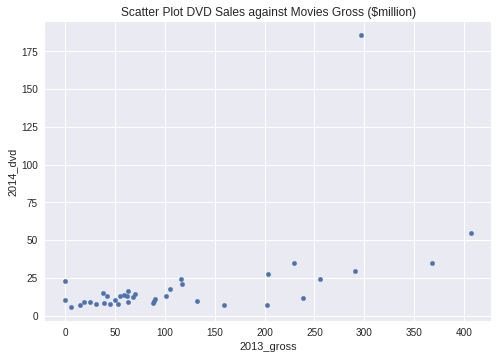

In [ ]:
# Scatter plot of the two data series
ax = movies.plot.scatter("2013_gross","2014_dvd", title = "Scatter Plot DVD Sales against Movies Gross ($million)")

Plotting the data, there appears to be a positive linear relationship of some kind with clusters at the lower end. The outlier for "Frozen" dvd sales is very clear from the plot. Outliers can be identified using a z-score, with a threshold of + or - 3 which is often used.

In [ ]:
# Sort by dvd sales to have a look at the outlier value
movies.sort_values(by = "2014_dvd",ascending = False).head(5)

,title,2013_gross,2014_dvd
2,Frozen,296.692,185.483
0,The Hunger Games: Catching Fire,407.140,54.925
1,Despicable Me 2,367.957,34.813
6,The Hobbit: The Desolation of Smaug,229.060,34.679
3,Man of Steel,291.046,29.803


The outlier is for 'Frozen' for dvd sales and for gross sales, "Hunger Games: Catching Fire" is the top seller.

A linear model would be appropriate but as linear regression can be sensitive to outliers, these were investigated further using z-scores. 

Running the code, the movie "Hunger Games: Catching Fire" had a z-score of 2.997 for gross movie sales and "Frozen" had a score of 5.71. 

Values outside + or - 3 are usually classed as outliers. The "Hunger Games" could be said to be borderline here so was left in the dataset but "Frozen" was removed.

In [ ]:
z = np.abs(stats.zscore(movies["2014_dvd"])) 
print(z)
thresh = 3
print(np.where(z > 3))

[1.20784224 0.51441713 5.70924415 0.34168146 0.15367196 0.29123444
 0.50979706 0.25617558 0.43462919 0.44997197 0.3442274  0.03685989
 0.14877606 0.08788215 0.24565429 0.31078357 0.36067349 0.38839395
 0.19900532 0.27165084 0.13025583 0.37560254 0.23851731 0.20528035
 0.2375864  0.43069867 0.32643666 0.4123218  0.22934612 0.40811547
 0.16066559 0.42628547 0.37174099 0.37098247 0.43483605 0.49493152
 0.3404348  0.09967913]
(array([2]),)


In [ ]:
z = np.abs(stats.zscore(movies["2013_gross"]))
print(z)
thresh = 3
print(np.where(z > 3))

[2.85605901 2.47544766 1.78320185 1.72835839 1.38426079 1.21969152
 1.12624587 0.87746867 0.86689046 0.45135842 0.18884606 0.04369446
 0.03087239 0.08043673 0.11161766 0.22179028 0.23143597 0.24471458
 0.41402412 0.43320865 0.48559456 0.48572084 0.49985425 0.52607149
 0.56553819 0.58139093 0.61088168 0.65707996 0.69055332 0.71829561
 0.72506605 0.7943052  0.85530715 0.91331728 0.94991845 1.04525827
 1.09541974 1.09559459]
(array([], dtype=int64),)


In [ ]:
movies.drop([2],inplace = True)
movies.reset_index(inplace= True,drop = True)

In [ ]:
# Relationship between the data series
movies.corr()

,2013_gross,2014_dvd
2013_gross,1.00000,0.76776
2014_dvd,0.76776,1.00000


Running the correlation matrix again, the coefficient has increased to 0.76

#### Linear Regression Using Function Created Earlier

In [ ]:
# Split out the two series
gross = movies["2013_gross"]
dvd = movies["2014_dvd"]

In [ ]:
# Run data through the linear function created earlier and display each table
result = my_func(gross,dvd)
display(result[0])
display(result[1])
display(result[2])

Slope of the line (B1):  0.0781
Intercept of the line (B0):  6.98 

R square value:  0.5895


T_crit: 2.03
Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y
F-crit:  4.12
Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model




,Coefficient,SE,T-Stat,P-Value,CI Lower 95%,CI Upper 95%
Intercept,6.975024,,,,,
Slope,0.078060,0.0110115,7.08891,2.93458e-08,0.0557051,0.100414


,Dof,SS,MS,F-Stat,P-Value
Regression,1,2243.075123,2243.08,50.2526,2.93458e-08
Residual,35,1562.260422,44.636,,
Total,36,3805.335545,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
Residuals,16.165,-0.887,0.113,-2.58,-14.164,9.819,4.463,-15.483,-12.588,-7.411,4.802,8.158,2.184,-2.142,-3.141,-4.508,-5.212,1.641,-0.306,4.215,-2.901,1.185,2.359,1.742,-3.729,-0.475,-2.586,2.981,-1.974,5.253,-1.891,0.181,0.663,-0.889,-1.872,3.019,15.784


In [ ]:
# test the function with the statsmodels linear regression 
gross_with_constant = sm.add_constant(gross)
simple_lr_model = sm.OLS(dvd,gross_with_constant).fit()
simple_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               2014_dvd   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     50.25
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           2.93e-08
Time:                        17:26:21   Log-Likelihood:                -121.75
No. Observations:                  37   AIC:                             247.5
Df Residuals:                      35   BIC:                             250.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9750      1.620      4.305      0.000       3.686      10.264
2013_gross     0.0781      0.011      7.089      0.000       0.056       0.100
==============================================================================
Omnibus:                        2.970   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.084
Skew:                           0.078   Prob(JB):                        0.353
Kurtosis:                       4.152   Cond. No.                         217.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpret the Model

The estimated regression line is $6.98 + 0.0781x$ 

The constant (6.98) is the average estimated value of dvd sales in millions when gross movie sales is zero but as this is not within the range of movie gross sales values, it is not relevant. The slope coefficient is the estimated change in the average value of dvd sales from a one unit increase in movie sales. For a million dollar increase in gross movie sales, dvd sales increase by 1000000 * 0.0781 = 78,100 dollars.

The R square value is 0.59, so this indicates that 59% of the variation in dvd sales can be attributed to movie sales and 4!% to other factors, which is interesting. The adjusted rsquared is the rsquared adjusted for the number of independent variables in the model whch in this case is one.

The standard error of the regression is 0.0110, so the average distance of the data points from the regression line. The points are 0.0110 million dollars or 11,000 dollars on average away from the regression line.

The T- statistic which tests for a positive linear relationship of the slope is well above the critical value and the related p-value is very small, below 0.05, so we can reject the null hypothesis of no linear relationship and conclude that the dvd sales are affected by the changes in movie sales. 

The F-statistic and p-value for the overall model similarly allows us to reject the null hypothesis as there is sufficient evidence that the model is a significantly better fit to the data than a model with no independent variable. 

The p-value for the F stat and T-stats are the same as there is only one independent variable.

The confidence intervals for the slope, we are 95% confident that the average impact on dvd sales is between 55,705 and 100,414 per million of movie sales. 

### Plot the line

In [ ]:
# Finding predicted values of dvd sales using the coefficients found in the model from task 1 and applying this to the gross movies sales
def predict(ind_var1,sl,int):
  predict_y = ind_var1 * sl + int
  return predict_y

# predict(x,slope,y)

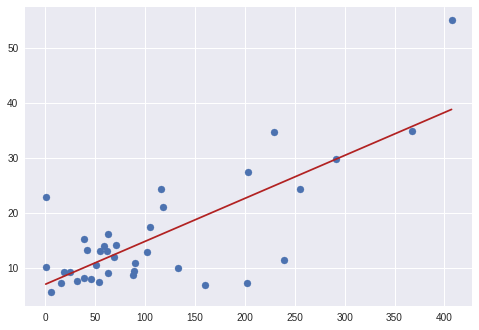

In [ ]:
predicted_dvd = predict(gross,result[0]["Coefficient"].loc["Slope"],result[0]["Coefficient"].loc["Intercept"])  
plt.scatter(gross,dvd)
ax = plt.plot(gross, predicted_dvd,'firebrick')

### How much of the variation in the reponse variable is explained by the variation in the regression model?

The proportion  of variation in the observed values  of the  response  variable  explained  by the regression is 59%, with 41% not accounted for by gross movie sales.

### Check that the assumptions of your model are satisfied.

### Linearity

The relationship between dvd and movie sales should be linear. We have already established that from the scatter plots above, there is a positive linear relationship between the variables supported by a relatively strong correlation coefficient of 0.76.


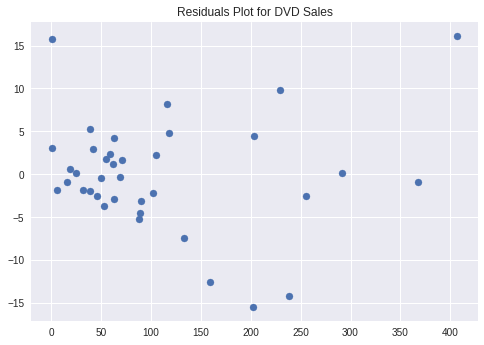

In [ ]:
# Plot the residuals
residuals_movies = result[2].transpose()
plt.scatter(gross,residuals_movies)
ax = plt.title("Residuals Plot for DVD Sales")

In [ ]:
sm.stats.diagnostic.linear_harvey_collier(simple_lr_model)

Ttest_1sampResult(statistic=2.9112331189745393, pvalue=0.00640659834158777)

In [ ]:
sm.stats.diagnostic.linear_rainbow(simple_lr_model)

(5.336739486345278, 0.0007127364106168192)

Looking at the residuals plot, it does not appear strongly linear and there may even be some kind of curvilinear pattern from around the mid-range of the plot. DVD sales for block-busters do not appear to have the same relationship with gross sales as lower return movies seem to do with their gross sales and appear more unpredictable, sometimes selling a lot more and sometimes a lot less than expected. There can also be surprise DVD hits that were Box Office flops which can be seen clearly on the residuals plot.

Running two linearity tests from statsmodels (the harvey_collier and rainbow tests) the null hypothesis of linearity is rejected. The residuals do not appear to meet the linearity assumption which is likely to affect the reliability of predictions made from the model.

### Independence

The residuals should be statistically independent. There should be no autocorrelation in the between sequential observations so one residual should not be related to the previous one.  We expect to see a random distribution of points oscillating around zero, indicating no relationship. The independence assumption is violated when the value of one observation is too similar to others. The plot does not seem to meet the independence assumption as noted above there appear to be some patterns in the data.

This is not a time series analysis so serial autocorrelation should not be an issue. However seasonal factors are relevant for movie releases. Block buster movies are usually released around Christmas, prior to the summer and Easter. Other months are referred to as 'dump' months, where audiences and takings are expected to be lower and movies expected to be less popular are released. These two types of movies are likely to have similarities amongst themselves, blockbusters are often felt to be increasingly formulaic and there is also the phenomena of 'twin' movies with similar plots released at the same time. The datapoints could therefore have some relationships affecting independence.


[Dump Months](https://en.wikipedia.org/wiki/Dump_months)

[Twin Films](https://en.wikipedia.org/wiki/Twin_films)

### Normality

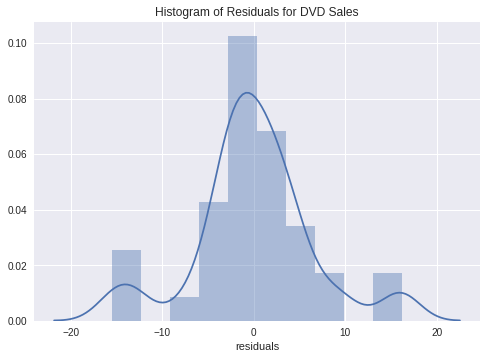

In [ ]:
sns.distplot(residuals_movies)
plt.title("Histogram of Residuals for DVD Sales")
plt.xlabel('residuals')
plt.show()

In [ ]:
tester = residuals_movies.sort_values(by = "Residuals")

In [ ]:
residuals_movies.skew()

Residuals    0.081587
dtype: float64

In [ ]:
# Shapiro Wilks test for normal distribution
stats.shapiro(residuals_movies)

(0.941680908203125, 0.052176155149936676)

In [ ]:
# (Jarque-Bera', Chi^2 two-tail prob.,'Skew','Kurtosis')
sm.stats.stattools.jarque_bera(residuals_movies, axis=0)

(array([2.08720085]),
 array([0.35218438]),
 array([0.07824139]),
 array([4.15298445]))

In [ ]:
sm.stats.stattools.omni_normtest(residuals_movies)

NormaltestResult(statistic=array([2.9718548]), pvalue=array([0.22629238]))

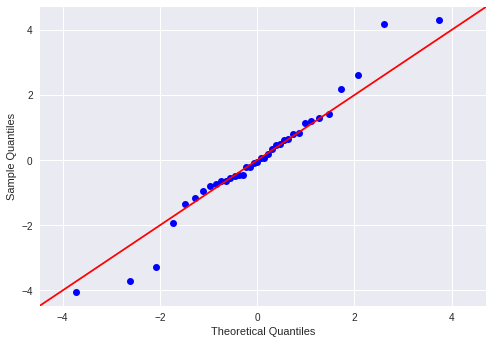

In [ ]:
fig = sm.qqplot(residuals_movies.sort_values(by = "Residuals"), stats.t, fit=True, line='45')
plt.show()

The histogram appears near fairly normally shaped, apart from some larger values around the tails. The qq plot also shows this variance quite clearly about the top and bottom of the line. There is a slight positive skew to the data. The statistical tests fail to reject the null hypothesis of normality.

### Equality of Variance

The variation of residuals around the regression line should be constant at all gross movie sales for the assumption to be met.

For constant variance, we would want to see residuals dotted around the 0 line, or forming a band around it with no obvious outliers. Looking at the scatter plot showing residuals versus predicted values the plot has a cluster of residuals at the lower gross movie sales and there does appear to be some variance across the takings range, with a vague fanning out type effect. This data set has a large range between the largest and smallest values, which can contribute to this.


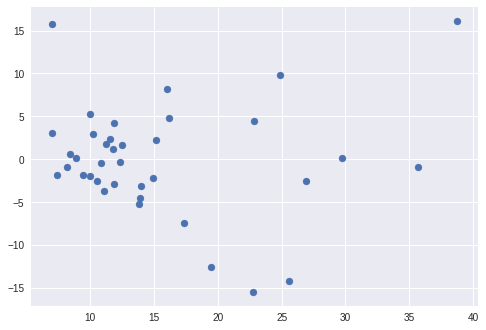

In [ ]:
ax = plt.scatter(predicted_dvd,residuals_movies)

In [ ]:
# Breusch pagan test for heteroscedascity ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
sm.stats.diagnostic.het_breuschpagan(residuals_movies, simple_lr_model.model.exog)

(6.548367027620818,
 0.010498046604331542,
 7.526455023762289,
 0.009522353469248712)

In [ ]:
# White test for heteroscedascity ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
sm.stats.diagnostic.het_white(residuals_movies,simple_lr_model.model.exog)

(6.861238968785035,
 0.03236688378171478,
 3.8701346199513464,
 0.030598659869729806)

As already discussed above, the residuals plot appears to show a fan shape with residuals radiating out with a larger variation around the higher grossing movies. Heteroscedascity will affect the reliability of any confidence intervals and can affect coefficients since there is higher variation in one part of the data.

A log transformation of the gross sales would help to address this and is carried out at the end of this question. 


### Use a t-test and an F-test to test the null hypothesis that there is no linear relationship between your  x  and  y  variables.

NOTE: This question was answered in question 2. of this task above. The linear function produced T-test and F-test results that indicated that we should reject the Null Hypothesis and accept the Alternative Hypothesis that there is a linear relationship between gross movie sales and dvd sales. 

The code is run again here to show the results in the right order for the question.

Ho: There is no linear relationship between gross movie sales and dvd sales

H1: There is a linear relationship between gross movies sales and dvd sales

Testing at the 95% significance level


In [ ]:
# Run movie results for the linear regression function and run the first table.
result = my_func(gross,dvd)
display(result[0])
display(result[1])

Slope of the line (B1):  0.0781
Intercept of the line (B0):  6.98 

R square value:  0.5895


T_crit: 2.03
Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y
F-crit:  4.12
Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model




,Coefficient,SE,T-Stat,P-Value,CI Lower 95%,CI Upper 95%
Intercept,6.975024,,,,,
Slope,0.078060,0.0110115,7.08891,2.93458e-08,0.0557051,0.100414


,Dof,SS,MS,F-Stat,P-Value
Regression,1,2243.075123,2243.08,50.2526,2.93458e-08
Residual,35,1562.260422,44.636,,
Total,36,3805.335545,,,


For the T-test:

The T-critical value is 2.03 is below the test statistic of 7.09 from the table. The p-value from the table is very small, well below the 5% significance level. The null hypothesis is rejected, dvd sales have a linear relationship to gross movie sales.

For the F-Test:

The F-critical value is 4.12 which is below the test statistic and the p-value is the same as for the t-test.The null hypothesis is rejected, the linear model is a better fit to the data than an intercept only model.

### Plot the 95% confidence interval for the mean value of  y  for a given  x  on a scatter plot with the simple linear regression line.

We shall now see how we can obtain the confidence intervals for mean y value for a given x_i and the prediction interval for the value of y given an x_i.

In [ ]:
# Use the function defined earlier to create CIs and PIs for all the values of x
slope = result[0]["Coefficient"].loc["Slope"]
intercept = result[0]["Coefficient"].loc["Intercept"]
conf = []
for i in gross:
  int = conf_int(i,gross,slope,intercept)
  conf.append(int)

conf_data = pd.concat(conf).reset_index(drop = True)
conf_data.head()

,CI lower,CI Upper,PI Lower,PI Upper
0,31.710420,45.802096,23.472151,54.040365
1,29.476528,41.918760,20.775768,50.619520
2,25.037009,34.350977,15.353574,44.034411
3,22.948937,30.908674,12.793762,41.063849
4,21.934023,29.278612,11.554775,39.657860


In [ ]:
# Test confidence intervals with statsmodels code
#simple_lr_model.get_prediction(gross_with_constant).summary_frame(alpha = 0.05)

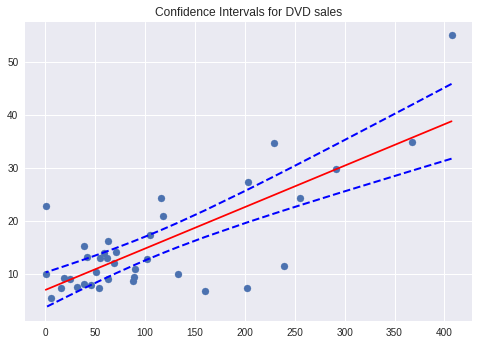

In [ ]:
# Plotting confidence intervals on a graph
plt.scatter(gross,dvd)
plt.plot(gross, predicted_dvd,'r')
plt.plot(gross, conf_data["CI lower"],'b--',lw=2)
plt.plot(gross, conf_data["CI Upper"],'b--',lw=2)
plt.title("Confidence Intervals for DVD sales")
plt.autoscale(enable = True)
plt.show()

The effect of the variance across the dataset is apparent in the confidence intervals that are narrower for the lower grossing movies and wider for the higher grossing ones.

### On the same plot now also include the 95% prediction interval for the value of  y  for a given  x .

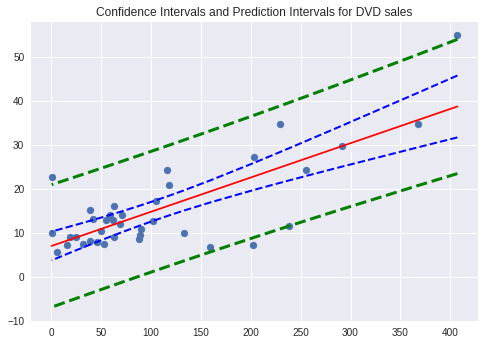

In [ ]:
# Plotting prediction intervals on a graph
plt.scatter(gross,dvd)
plt.plot(gross, predicted_dvd,'r')
plt.plot(gross, conf_data["CI lower"],'b--',lw=2)
plt.plot(gross, conf_data["CI Upper"],'b--',lw=2)
plt.plot(gross, conf_data["PI Lower"], 'g--', lw = 3)
plt.plot(gross,conf_data["PI Upper"], 'g--', lw = 3)
plt.title("Confidence Intervals and Prediction Intervals for DVD sales")
plt.autoscale(enable = True)
plt.show()


Prediction intervals are wider than the confidence intervals, since they include uncertainty in the estimation of the population mean as well as the random variation of the individual value. The prediction interval also does not converge to one value with increasing sample size.

### Investigating the effect of log transformation on the dependent variable 

The model above didn't appear to meet the homoscadiscity assumption so the dependent variable was log transformed. This was felt to be appropriate as the residuals seemed to be roughly varying in scale with the predictions and the data was positive. The model was then back transformed to the original scale. The CIs and PIs associated with these results is shown below and this non-linear model appears to fit the data better, with increasing intervals as the data varies and most of the datapoints falling within the intervals. 

An alternative approach may have been to consider blockbusters and lower revenue movies as separate datasets for modelling purposes and develop two different models.

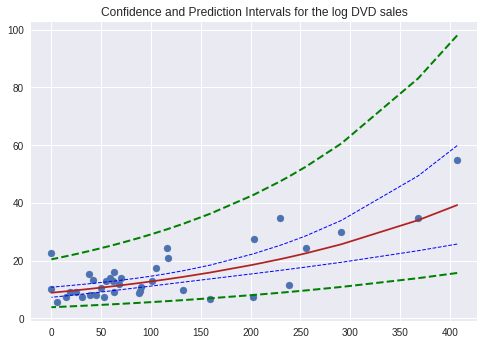

In [ ]:
# log the dvd sales data, get predicted, CIs and PIs and transform back to original scale
dvd_log = np.log(dvd)
simple_lr_model = sm.OLS(dvd_log,gross_with_constant).fit()
y_predict_log = simple_lr_model.predict(gross_with_constant)
resid = simple_lr_model.resid
conf = simple_lr_model.get_prediction(gross_with_constant).summary_frame(alpha = 0.05)
conf_back = conf.apply(lambda x: np.exp(x))
y_predict_new = np.exp(y_predict_log)
plt.scatter(gross,dvd)
plt.plot(gross,y_predict_new,'firebrick')
plt.plot(gross, conf_back["mean_ci_lower"],'b--',lw=1)
plt.plot(gross,conf_back["mean_ci_upper"],'b--',lw=1)
plt.title("Confidence and Prediction Intervals for the log DVD sales")
plt.plot(gross,conf_back["obs_ci_lower"],'g--',lw=2)
ax = plt.plot(gross, conf_back["obs_ci_upper"],'g--',lw=2)


In [ ]:
# Running the statistical test for constant variance on the logged data - the null hypothesis of constant variance fails to be rejected.
sm.stats.diagnostic.het_breuschpagan(resid, simple_lr_model.model.exog)

(0.3234131662055968, 0.5695636409602167, 0.308629068143437, 0.5820566002488499)

## Task 5 - 20 %

The task is now to use your linear regression model to the following data:

https://github.com/cm326/Data/raw/master/Beer.csv

This data contains information about the price of an 18-pack beer for a certain brand each week over the course of 52 weeks. Also included in the data is the corresponding sales of the 18-pack each week (number of sales). The task is to try and model the sales of beer in terms of the price.

With this in mind complete the following:

1. Fit your simple linear regression model with $y$ being the beer sales and $x$ the price. Interpret your model. 

3. Plot the line of your simple linear regression model on top of the scatter of the data.

4. How much of the variation in the reponse variable is explained by the variation in your regression model?

6. Check that the assumptions of your model are satisfied.

7. Now try fitting a linear regression model where $x$ and $y$ are the natural log of the price and sales per week respectively. Interpret your model.  

8. Plot the new model on top of the scatter of the log data.

9. Now how much of the variation in the reponse variable is explained by the variation in your regression model?

10. Check that the assumptions of your model are satisfied in this case.

11. Plot the 95% confidence interval for the mean value of $y$ for a given $x$ on a scatter plot with the simple linear regression line. (For the log-data model)

12. On the same plot now also include the 95% prediction interval for the value of $y$ for a given $x$. (For the log-data model)

13. Transform the data back to the original scale and plot the model on the data with the confidence and prediction intervals from 11. and 12.

#### 1. Analysis of the data, fit the model and interpret results of regression

In [ ]:
beer = pd.read_csv("https://raw.githubusercontent.com/cm326/Data/master/Beer.csv")
beer = beer.set_index("Week")
beer.head()

,PRICE 18PK,CASES 18PK
Week,,
1,14.10,439
2,18.65,98
3,18.65,70
4,18.65,52
5,18.65,64


In [ ]:
beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 2 columns):
PRICE 18PK    52 non-null float64
CASES 18PK    52 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [ ]:
beer.describe().T

,count,mean,std,min,25%,50%,75%,max
PRICE 18PK,52.0,16.724615,2.411076,13.26,14.09,18.65,18.75,19.5
CASES 18PK,52.0,256.673077,258.825456,32.00,63.00,88.00,457.00,890.0


The mean number of cases sold is 257 and the mean price is $16.72. 

The standard deviation of 258 and IQR indicates there is variance in sales which can be seen looking at the original dataset.

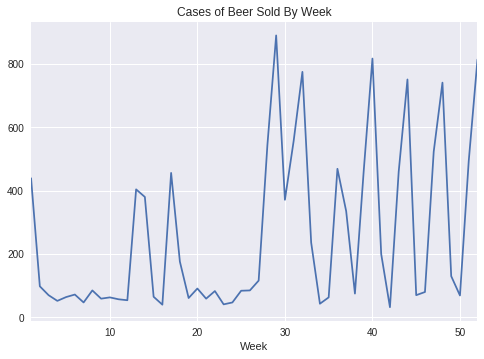

In [ ]:
ax = beer["CASES 18PK"].plot(title = "Cases of Beer Sold By Week")

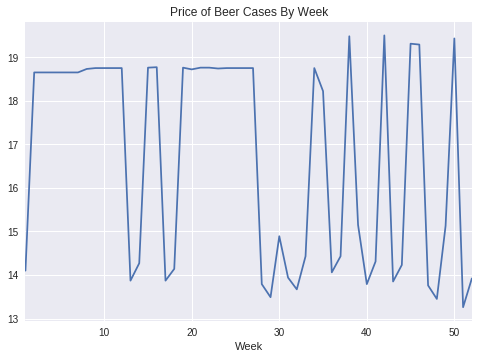

In [ ]:
ax = beer["PRICE 18PK"].plot(title = "Price of Beer Cases By Week")

There does seem to be a relationship in periods where the price is set higher, sales appear low and when there are price reductions the sales seem to shoot up. This is clearly seen over the first half of the year.

Text(17, 400, 'mean ($16.7, 256.7 cases)')

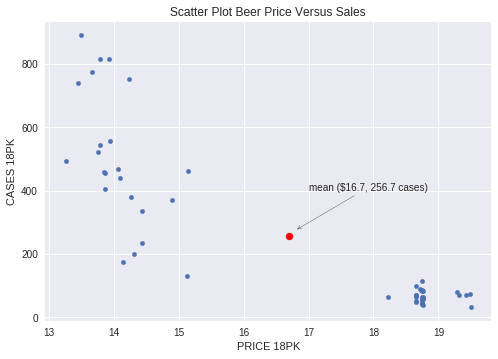

In [ ]:
ax = beer.plot.scatter("PRICE 18PK","CASES 18PK",title = "Scatter Plot Beer Price Versus Sales")
plt.scatter(16.7, 256.7, s=50, color = "r")
ax.annotate('mean ($16.7, 256.7 cases)', xy=(16.8,275), xytext=(17,400),
            arrowprops=dict(facecolor='blue',arrowstyle ='->'))

Looking at a scatter plot there is clearly a relationship between price and cases of beer sold. However, the pattern of data with clustering at the higher prices and more widely spread points at the lower prices indicates that there might be some variance in the sales of beer over the different price points. The mean value shows that if the price was $16.7, we would expect to sell 256.7 cases of beer.

In [ ]:
beer.corr()

,PRICE 18PK,CASES 18PK
PRICE 18PK,1.000000,-0.866405
CASES 18PK,-0.866405,1.000000


In [ ]:
# Test for the significance of the correlation using t-statistic at 0.05 significance and 52-2 degrees freedom. 
# Null hypothesis of no correlation between the variables
test_stat = (-0.866405-0)/((1-(-0.866405**2))/(52-2)**0.5)
t_critical = stats.t.ppf(0.975,50)
if test_stat>t_critical or test_stat<-t_critical:
  print("Reject H0: There is a statistically significant relationship between price and sales of beer")
else:
  print("Fail to reject H0: There is no statistically significant relationship between price and sales of beer")

Reject H0: There is a statistically significant relationship between price and sales of beer


Running a correlation matrix, which shows strength and direction of relationships between variables, the sales of beer are quite highly inversely correlated with the price.

In [ ]:
# Splitting out the data into x and y
price_beer = beer["PRICE 18PK"].reset_index(drop = True)
sales_beer = beer["CASES 18PK"].reset_index(drop = True)

In [ ]:
# Running the linear regression function - NOTE: Uses the linear function compiled in Task 2
result = my_func(price_beer,sales_beer)
display(result[0],result[1],result[2])

Slope of the line (B1):  -93.0073
Intercept of the line (B0):  1812.18 

R square value:  0.7507


T_crit: 2.01
Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y
F-crit:  4.03
Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model




,Coefficient,SE,T-Stat,P-Value,CI Lower 95%,CI Upper 95%
Intercept,1812.183939,,,,,
Slope,-93.007273,7.5807,-12.269,1.0709e-16,-108.234,-77.781


,Dof,SS,MS,F-Stat,P-Value
Regression,1,2.564637e+06,2.56464e+06,150.527,1.0709e-16
Residual,50,8.518848e+05,17037.7,,
Total,51,3.416521e+06,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Residuals,-61.78,20.4,-7.6,-25.6,-13.6,-5.6,-30.6,14.84,-9.3,-5.3,-11.3,-14.3,-118.17,-104.97,-2.37,-26.44,-66.17,-321.06,-6.37,19.91,-8.37,15.63,-28.23,-21.3,15.7,16.7,47.7,14.39,332.48,-56.31,41.34,234.23,-234.09,-25.3,-54.59,-35.5,-135.09,74.6,57.88,287.39,-281.25,33.46,-64.03,262.31,53.79,61.93,-9.4,179.76,-274.98,63.95,-85.91,296.48


The linear regression of price of beer to sales of beer, shows an inverse relationship. 

The equation is y = $1812 - 93x$

So for each $1 increase in price, the number of cases of beer sold will fall by around 93 cases. The intercept of the line that can be produced from this equation is 1812 cases, where the price of beer is zero. As the cases are not priced at zero, this has no practical application.

The r-squared value of 0.75, means that around 75% of the variation in beer cases sold can be explained by variation in the price of beer. 25% is explained by other factors not in the model. 

The standard error of the regression of 7.587 is the standard deviation in beer sales that is not related to the price of beer and therefore is a measure of the accuracy of predictions from the model. The data points are 7.6 cases on average away from the regression line.

The t-statistic is  greater than the critical value and the p-value is below 0.05, so significant. The null hypothesis of no relationship between beer sales and price is rejected.

The F-statistic is greater than the critical value and the p-value is below 0.05, so also significant. The null hypothesis that the model and an intercept only model with no independent variables is rejected. 

The confidence interval is between -108 and -78 cases which doesn't really make much sense.

Checking these results from the function with the OLS in the statsmodel package:


In [ ]:
# Check results with statsmodels
price_with_constant = sm.add_constant(price_beer)
simple_lr_model = sm.OLS(sales_beer,price_with_constant).fit()
simple_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CASES 18PK   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     150.5
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.07e-16
Time:                        17:26:24   Log-Likelihood:                -326.09
No. Observations:                  52   AIC:                             656.2
Df Residuals:                      50   BIC:                             660.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1812.1839    128.070     14.150      0.000    1554.948    2069.420
PRICE 18PK   -93.0073      7.581    -12.269      0.000    -108.234     -77.781
==============================================================================
Omnibus:                        4.862   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                5.119
Skew:                           0.262   Prob(JB):                       0.0774
Kurtosis:                       4.445   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2. Plot the line on the scatter graph

In [ ]:
# Finding predicted values of sales of beer using the coefficients found in the model from task 1 and applying this to the price of beer (x)
def predict(ind_var1,sl,int):
  predict_y = ind_var1 * sl + int
  return predict_y

# predict(ind_var,s1,int)

In [ ]:
predicted_y = pd.Series(predict(price_beer,result[0]["Coefficient"].loc["Slope"],result[0]["Coefficient"].loc["Intercept"]))

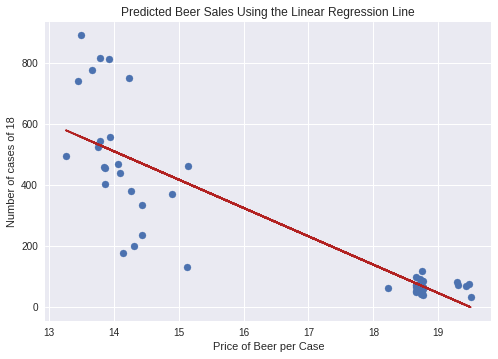

In [ ]:
# Using the linear function to graph predicted sales against price of beer
plt.scatter(price_beer,sales_beer)
plt.title("Predicted Beer Sales Using the Linear Regression Line")
plt.xlabel("Price of Beer per Case")
plt.ylabel("Number of cases of 18")
ax = plt.plot(price_beer, predicted_y,'firebrick')

The intercept is not shown due to scaling of the plot but if we rescale the axes, and project the line, the intercept at around 1800 cases can be confirmed. As stated before, this has no practical use but nevertheless interesting.

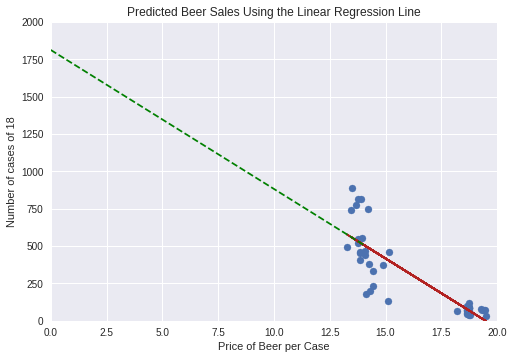

In [ ]:
# Using the linear function to graph predicted sales against price of beer - extending the line
plt.scatter(price_beer,sales_beer)
ax = plt.plot(price_beer, predicted_y,'firebrick')
plt.title("Predicted Beer Sales Using the Linear Regression Line")
plt.xlabel("Price of Beer per Case")
plt.ylabel("Number of cases of 18")
plt.xlim(0,20) 
plt.ylim(0,2000)
x1, y1 = [0,14.10], [1812,501]
plt.plot(x1, y1,linestyle = '--',color = "g")
plt.show()

#### 3. Variation in the reponse variable explained by the variation in the regression model

From the linear regression function "Analysis of Results" above, we can see that the R square value is:  0.7507 , So 75 % of the variation in the sales of beer cases can be explained by the variation in the beer price. The remaining 25% is explained by other factors not involved in the model.

#### 4. Check assumptions of the model are satisfied

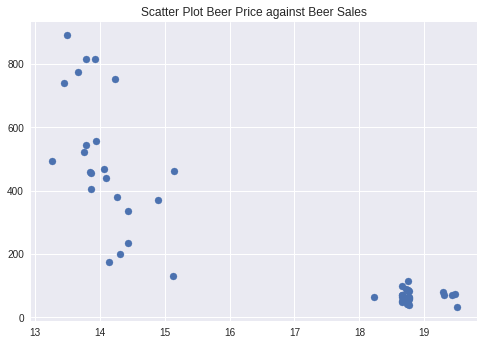

In [ ]:
plt.scatter(price_beer,sales_beer)
ax = plt.title("Scatter Plot Beer Price against Beer Sales")

### Linearity

The relationship between beer price and cases sold should be linear. From the scatter plot above we can see that there is a roughly negatively linear relationship. The correlation matrix from task 1 of -0.87 supports a fairly strong relationship, albeit negative between the variables.

The harvey collier test for linearity from statsmodels fails to reject the null hypothesis of linearity. 


In [ ]:
# Test the null hypothesis of linearity is correct using statsmodels on the results of the simple_lr_model
sm.stats.diagnostic.linear_harvey_collier(simple_lr_model)

Ttest_1sampResult(statistic=1.1565656871825603, pvalue=0.25317366634846455)

### Independence 

The residuals are assumed to be statistically independent. As this is data is collected over time, there should be no autocorrelation in the between sequential observations so one residual should not be related to the previous one. We expect to see a random distribution of points osciallating around zero, indicating no relationship.

In [ ]:
residuals_beer = sales_beer - predicted_y
residuals_beer = result[2].transpose()

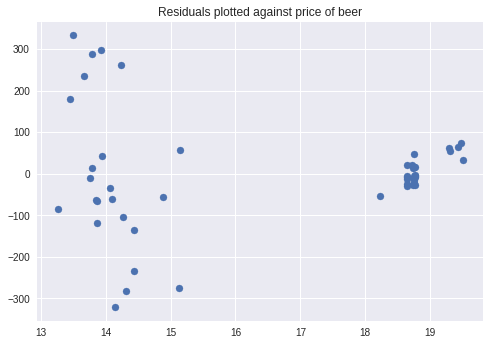

In [ ]:
plt.scatter(price_beer,residuals_beer)
ax = plt.title("Residuals plotted against price of beer")

The cluster of values at the higher price range and relatively spread out values at the lower price range suggests there might be some issues with the data which need to be investigated further.

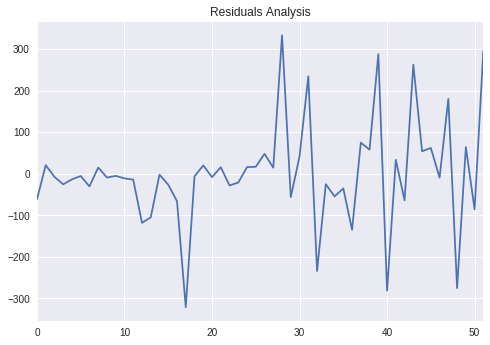

In [ ]:
ax = residuals_beer["Residuals"].plot(title = "Residuals Analysis")

Plotting the residuals over time, there appears to be a pattern arising from around the mid-year mark of increased variance, which matches the price chart over the year produced earlier.

Running the Durbin-Watson test to test for autocorrelation:

H0: No positive autocorrelation in the residuals

H1: There is autocorrelation in the residuals

In [ ]:
# Durbin-Watson Test Statistic
sm.stats.stattools.durbin_watson(residuals_beer, axis=0)

array([2.33569369])

The test statistic of 2.336 is close to 2 but as it is above 2, the value was compared to the DW tables.

Using the DW tables with k = 1 and n = 52:

The test statistic is not lower than the DW lower value of approx. 1.5 and is higher than the upper value of approx. 1.59 so we fail to reject the null hypothesis of no positive autocorrelation in the residuals.

### Normality

The residuals are assumed to be normally distributed around the regression line at each price value.

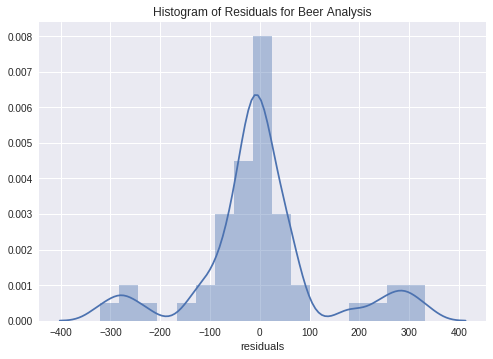

In [ ]:
sns.distplot(residuals_beer)
plt.title("Histogram of Residuals for Beer Analysis")
plt.xlabel('residuals')
plt.show()

In [ ]:
residuals_beer.skew()

Residuals    0.270247
dtype: float64

In [ ]:
stats.shapiro(residuals_beer)

(0.8921141624450684, 0.00020179127750452608)

In [ ]:
# Jarque Bera - (Jarque-Bera', Chi^2 two-tail prob.,'Skew','Kurtosis')
sm.stats.stattools.jarque_bera(residuals_beer, axis=0)

(array([5.11848924]),
 array([0.07736316]),
 array([0.26238764]),
 array([4.44464202]))

In [ ]:
sm.stats.stattools.omni_normtest(residuals_beer)

NormaltestResult(statistic=array([4.86172566]), pvalue=array([0.0879609]))

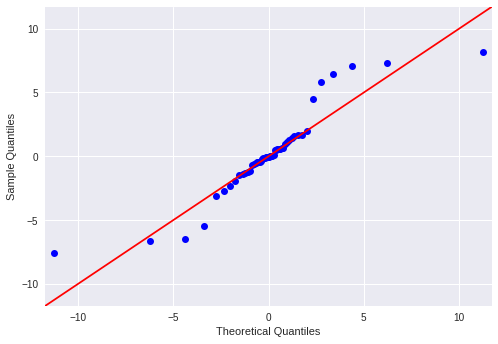

In [ ]:
fig = sm.qqplot(residuals_beer.sort_values(by = "Residuals"), stats.t, fit=True, line='45')
plt.show()

The histogram at first glance appears roughly normal but there are humps around the tails reflecting outliers. This is also shown in the qq-plot, where the residuals appear to be oscillating around the normal line with the results at each end straying away from the line. 

The skew is slightly positive and the Shapiro-Wilks test has a low p-value so we reject the null hypothesis of normality.

Running another statsmodel test (Jarque Bera) goodness of fit, which tests whether the skew and kurtosis matches the normal distribution, the kurtosis of 4.4 is quite high. The tails of the distribution are heavier than a normal distribution and the skewness is slightly positive. However, the test statistic does not support failing to accept the null hypothesis.

https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html?highlight=residuals

In summary, as the Shapiro-Wilks test is generally considered to be more reliable on smaller datasets of less than 2000 and there does appear to be some issues with the histogram and qq-plot, it is felt the residuals are not normally distributed.

### Equal Variance or Homoscedasticity

The variation of residuals around the regression line is assumed to be constant at all prices of beer.

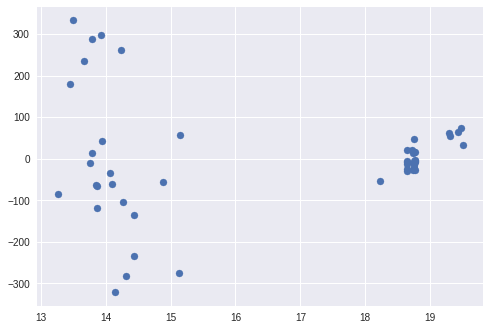

In [ ]:
ax = plt.scatter(price_beer,residuals_beer)

In [ ]:
# Breusch Pagan - ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
sm.stats.diagnostic.het_breuschpagan(residuals_beer, simple_lr_model.model.exog)

(16.312895918895254,
 5.369727477252053e-05,
 22.855449242703394,
 1.5776274698237233e-05)

In [ ]:
# White test
sm.stats.diagnostic.het_white(residuals_beer,simple_lr_model.model.exog)

(16.313800297569237,
 0.00028674990054656504,
 11.200074836302104,
 9.866780517411439e-05)

For constant variance, we would want to see residuals dotted around the 0 line, or forming a band around it with no obvious outliers. The plot clearly has a cluster of values at the higher price range and scattered values at the lower price end, suggesting our linear model is not performing well in picking up the relationship. The plot indicates variance in the residuals across the price range, so the assumption of homescadasticity is not met, our residuals are non-stationary. 

Further, the Breusch Pagan test and White test (from Statsmodels) return very small p-values so we can reject the null hypothesis of homoscedascity. This interesting since the R-squared value of 75% is on the face of it very good. 

The OLS method does not perform well with non-constant variance. The estimates of the parameters are likely to be biased and the confidence intervals may be worse. Using the model for prediction is also not a good idea. The data needs to be transformed or another model used.

The use of a log transformation will have the effect of spreading out any clusters of data or bring together very dispersed data.


#### 5. Fitting a linear regression model where  x  and  y  are the natural log of the price and sales per week respectively. 

In [ ]:
# Set up the two new variables
price_log = np.log(price_beer)
sales_log = np.log(sales_beer)

In [ ]:
# correlation coefficient for the log data - strength of linear relationship between the log variables
np.corrcoef(price_log,sales_log)

array([[ 1.        , -0.94241805],
       [-0.94241805,  1.        ]])

In [ ]:
# Using my_func determined earlier
result= my_func(price_log,sales_log)
display(result[0],result[1],result[2])

Slope of the line (B1):  -6.7052
Intercept of the line (B0):  23.83 

R square value:  0.8882


T_crit: 2.01
Reject null hypothesis B1 = 0, there is sufficient evidence that the independent variable x affects the dependent variable y
F-crit:  4.03
Reject Null Hypothesis B1 = 0, there is sufficient evidence that the model fits the data better than an intercept only model




,Coefficient,SE,T-Stat,P-Value,CI Lower 95%,CI Upper 95%
Intercept,23.831266,,,,,
Slope,-6.705213,0.33651,-19.9257,1.95308e-25,-7.38111,-6.02931


,Dof,SS,MS,F-Stat,P-Value
Regression,1,50.282970,50.283,397.034,1.95308e-25
Residual,50,6.332319,0.126646,,
Total,51,56.615289,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Residuals,-0.005501,0.374967,0.038495,-0.258756,-0.051117,0.066666,-0.359852,0.262651,-0.102463,-0.036865,-0.136949,-0.191016,-0.198585,-0.069829,0.004387,-0.481121,-0.077507,-0.899516,-0.059126,0.32086,-0.092463,0.248841,-0.466428,-0.329852,0.250817,0.262651,0.57359,0.058949,0.411221,0.196202,0.162565,0.352863,-0.466168,-0.4188,-0.226865,0.040603,-0.115869,0.397488,0.523398,0.465639,-0.691683,-0.444264,-0.078774,0.591406,0.268495,0.392027,0.009581,0.208001,-0.752466,0.294107,-0.299491,0.53196


In [ ]:
# Check function results with statsmodels linear regression:
price_log_constant = sm.add_constant(price_log)
simple_lr_log_model = sm.OLS(sales_log,price_log_constant).fit()
simple_lr_log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CASES 18PK   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     397.0
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.95e-25
Time:                        17:26:27   Log-Likelihood:                -19.040
No. Observations:                  52   AIC:                             42.08
Df Residuals:                      50   BIC:                             45.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8313      0.946     25.201      0.000      21.932      25.731
PRICE 18PK    -6.7052      0.337    -19.926      0.000      -7.381      -6.029
==============================================================================
Omnibus:                        1.593   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.553
Skew:                          -0.389   Prob(JB):                        0.460
Kurtosis:                       2.665   Cond. No.                         60.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared statistic has increased to 89% of the variation being explained by the model using log data. Interpreting much of the summary statistics is not straightforward since the log transformation has altered the scale. 

With a log of both the dependent and independent variables we can interpret the coefficient -6.7 in terms of percentage increase, so for each 1% increase in beer price, the sales decrease by around .06%. The standard error can't easily be interpreted as it is on a log scale.

[Source:](https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf)

The T-statistic and F-statistics are both significant, so the null hypotheses of no linear relationship and the models not fitting the data better than one with no independent variables respectively are rejected.


### Plot the new line on top of the scatter plot 

In [ ]:
# Get predicted values of y (log beer sales)
predicted_ylog = pd.Series(predict(price_log,result[0]["Coefficient"].loc["Slope"],result[0]["Coefficient"].loc["Intercept"]))

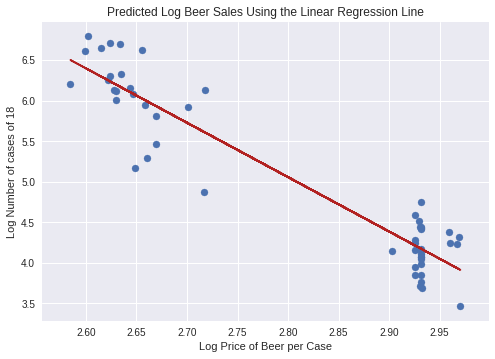

In [ ]:
# Using the linear function to graph log of predicted sales against log price of beer
plt.scatter(price_log,sales_log)
plt.title("Predicted Log Beer Sales Using the Linear Regression Line")
plt.xlabel("Log Price of Beer per Case")
plt.ylabel("Log Number of cases of 18")
ax = plt.plot(price_log, predicted_ylog,'firebrick')

### How much of the variation in the reponse variable is explained by the variation in the regression model?

As noted above with the results of the linear regression function, the R-squared statistic has increased to 89% of the variation being explained by the model and 11% by other factors.

### Check that the assumptions of are satisfied for the Log Data.
Linearity, Normality, Independence, Homoscasdicity

In [ ]:
residuals_log = sales_log - predicted_ylog

### Linearity

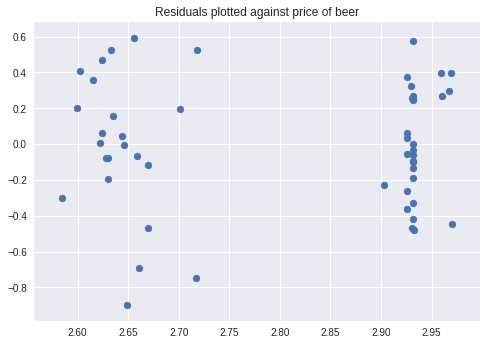

In [ ]:
# Plot residuals from log sales against the log price
plt.scatter(price_log,residuals_log)
ax = plt.title("Residuals plotted against price of beer")

In [ ]:
# Test the null hypothesis of linearity is correct using statsmodels on the results of the simple_lr_log_model
sm.stats.diagnostic.linear_harvey_collier(simple_lr_log_model)

Ttest_1sampResult(statistic=0.486240599971463, pvalue=0.6290092289538256)

The cluster of residuals appears more spread out above and below zero. The harvey collier test fails to reject the null hypothesis of linearity of the residuals with a p-value above 0.05 significance. Linearity is assumed to be met.

### Independence

In [ ]:
# Durbin-Watson Test Statistic
sm.stats.stattools.durbin_watson(residuals_log, axis=0)

1.7720033453646684

Using the DW tables with k = 1 and n = 52, the test statistic of 1.77 s not lower than the DW lower value of approx. 1.5 and is higher than the upper value of approx. 1.59 so we fail to reject the null hypothesis of no positive autocorrelation in the residuals and we can assume this condition is met. 

### Normality

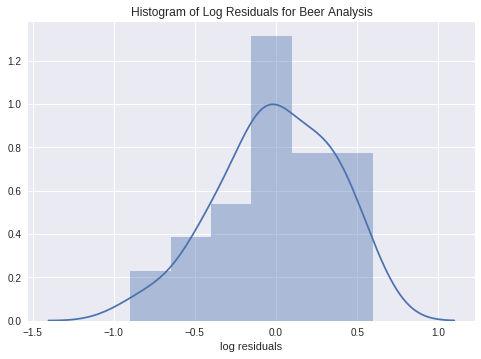

In [ ]:
sns.distplot(residuals_log)
plt.title("Histogram of Log Residuals for Beer Analysis")
plt.xlabel('log residuals')
plt.show()

In [ ]:
# Shapiro Wilks test for normality of residuals
stats.shapiro(residuals_log)

(0.9749875664710999, 0.33970770239830017)

In [ ]:
# Jacque Bera test (Jarque-Bera', Chi^2 two-tail prob.,'Skew','Kurtosis')
sm.stats.stattools.jarque_bera(residuals_log, axis=0)

(1.5533844771394993,
 0.4599248195717066,
 -0.38882413355698936,
 2.665022606118983)

In [ ]:
sm.stats.stattools.omni_normtest(residuals_log)

NormaltestResult(statistic=1.592859147744837, pvalue=0.4509361274121594)

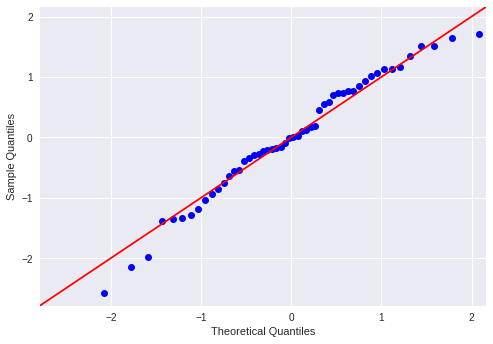

In [ ]:
fig = sm.qqplot(residuals_log, stats.t, fit=True, line='45')
plt.show()

The plots (histogram and qq plot) appear improved, with the qq plot showing most points along or close to the normal line. Looking at the test statistics, there is a very small negative skew and a kurtosis of 3 - normal. The Shapiro and Omni tests from Statsmodels fail to reject the null hypothesis of normality, so we the normality assumption has been met.

### Homoscedasticity

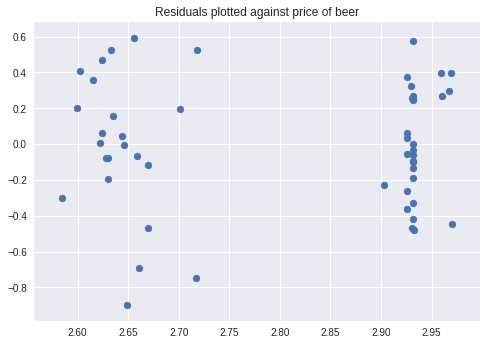

In [ ]:
# Plot residuals from log sales against the log price
plt.scatter(price_log,residuals_log)
ax = plt.title("Residuals plotted against price of beer")

In [ ]:
#Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
sm.stats.diagnostic.het_breuschpagan(residuals_log, simple_lr_log_model.model.exog)

(1.5671308740776455,
 0.21062417003006212,
 1.5536800713883505,
 0.21840119038171182)

Looking at the scatter plot again, there does not appear to be any significant pattern in the residuals, other than the clusters relating to low and high end prices. 

We fail to reject the null hypothesis for the statistical test of equality of variances. 

The log transformed model appears to be a better one.

### Plot the 95% confidence interval for the mean value of  y  for a given  x  on a scatter plot with the simple linear regression line. (For the log-data model)

In [ ]:
# Use the confidence intervals function defined earlier to create CIs and PIs for all the values of x

slope = result[0]["Coefficient"].loc["Slope"]
intercept = result[0]["Coefficient"].loc["Intercept"]

confs = []
for i in price_log:
  int = conf_int(i,price_log,slope,intercept)
  confs.append(int)

conf_table = pd.concat(confs).reset_index(drop = True)

In [ ]:
conf_table.head()

,CI lower,CI Upper,PI Lower,PI Upper
0,5.941334,6.234867,5.358394,6.817807
1,4.084964,4.340725,3.486701,4.938988
2,4.084964,4.340725,3.486701,4.938988
3,4.084964,4.340725,3.486701,4.938988
4,4.084964,4.340725,3.486701,4.938988


In [ ]:
# test code to check confidence intervals calculated by function (uncheck comment to test)
#simple_lr_log_model.get_prediction(price_log_constant).summary_frame(alpha = 0.05).head()

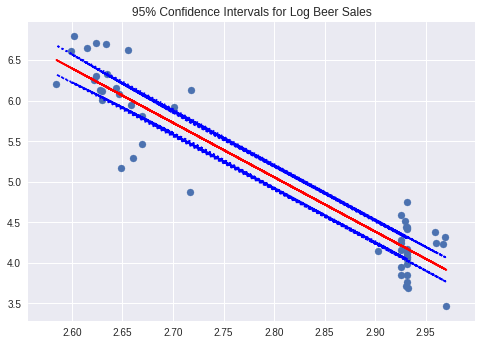

In [ ]:
# Plotting confidence intervals on a graph
plt.scatter(price_log,sales_log)
plt.plot(price_log, predicted_ylog,'r')
plt.plot(price_log, conf_table["CI lower"],'b:')
plt.plot(price_log, conf_table["CI Upper"],'b:')
plt.title("95% Confidence Intervals for Log Beer Sales")
plt.autoscale(enable = True)
plt.show()

On the same plot now also include the 95% prediction interval for the value of  y  for a given  x . (For the log-data model)

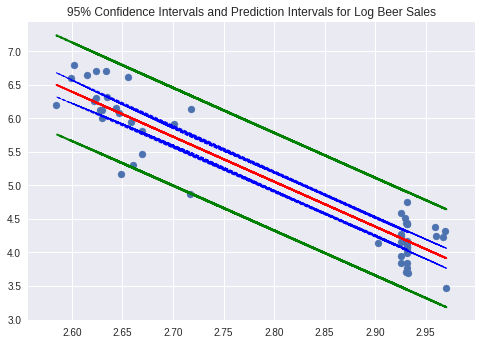

In [ ]:
# Plotting prediction intervals on a graph
plt.scatter(price_log,sales_log)
plt.plot(price_log, predicted_ylog,'r')
plt.plot(price_log, conf_table["CI lower"],'b--',lw=1)
plt.plot(price_log, conf_table["CI Upper"],'b--',lw=1)
plt.plot(price_log, conf_table["PI Lower"], 'g--', lw = 2)
plt.plot(price_log,conf_table["PI Upper"], 'g--', lw = 2)
plt.title("95% Confidence Intervals and Prediction Intervals for Log Beer Sales")
plt.autoscale(enable = True)
plt.show()

Transform the data back to the original scale and plot the model on the data with the confidence and prediction intervals from 11. and 12.

In [ ]:
# Add the log of predicted data to the table
conf_table["Log Predicted"] = predicted_ylog
conf_table.head()

,CI lower,CI Upper,PI Lower,PI Upper,Log Predicted
0,5.941334,6.234867,5.358394,6.817807,6.088100
1,4.084964,4.340725,3.486701,4.938988,4.212845
2,4.084964,4.340725,3.486701,4.938988,4.212845
3,4.084964,4.340725,3.486701,4.938988,4.212845
4,4.084964,4.340725,3.486701,4.938988,4.212845


In [ ]:
# apply exponential to the columns then add in the other columns for the original data
new = conf_table.apply(lambda x: np.exp(x))
new.columns = ["CI Lower","CI Upper","PI Lower","PI Upper","Y_predict"]
new["Original_predicted"] = predicted_y
new["Beer_Price"] = price_beer
new["Beer_Sales"] = sales_beer
new = new.sort_values(by = "Beer_Price")

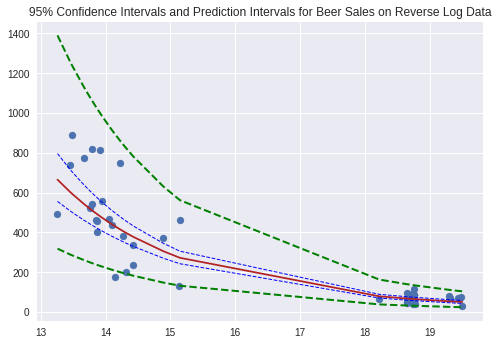

In [ ]:
plt.scatter(price_beer,sales_beer)
ax = plt.plot(new["Beer_Price"], new["Y_predict"],'firebrick')
plt.plot(new["Beer_Price"], new["CI Lower"],'b--',lw=1)
plt.plot(new["Beer_Price"], new["CI Upper"],'b--',lw=1)
plt.plot(new["Beer_Price"], new["PI Lower"], 'g--', lw = 2)
plt.plot(new["Beer_Price"],new["PI Upper"], 'g--', lw = 2)
plt.title("95% Confidence Intervals and Prediction Intervals for Beer Sales on Reverse Log Data")
plt.autoscale(enable = True)
plt.show()

The predicted values, Confidence Intervals and Prediction intervals seems to match the pattern in the data well, with wider intervals over the lower price ranges where there is more variation in the data. The lines are curves which slope downwards quite steeply over the low price range to those at the the higher prices. The corresponding intervals narrow to reflect the more clustered datapoints around the higher price points. The non-linear log transformed model appears to be more suitable for modelling this dataset.